# Objectives of analysis

As an international student without a driving license, I believe I would not live outside the City of Toronto.

But within the area, where should I live?

Common factors to consider include:
1. **Neighbourhood safety**
    - We can look into the various datasets provided by 
        - Toroto Police Services - [Public Safety Data Portal](https://data.torontopolice.on.ca/)
        - City of Toronto - [Open Data Portal](https://open.toronto.ca/)
        - All of the above materials are licensed under the [Open Government License - Toronto](https://open.toronto.ca/open-data-license/)
2. **Commute time**
    - We can measure the commute time and / or distance to a destination with the help of 
        - Google map or other location services
3. **Rental cost**
    - While rental cost and amenities provided by a unit are both important to consider, scraping information from real estate websites is often *prohibited by the copywright clause* under the terms of use
    - Although we cannot obtain these data through scraping, the information we collect about neighbourhood safety and commute time would create a useful filter for us
    > E.g. Realtor.ca's [terms of use](https://www.realtor.ca/terms-of-use) explicitly states that **scraping** and any other activity intended to collect, store, reorganize or manipulate data on the pages produced by, or displayed on the CREA websites are prohibited

 

# Existing resources

While we have 

Toronto Regional Real Estate Board (TRREB) [search engine](https://onlistings.trreb.ca/searchlistings#search/d17c8105b8d19ca9a20f2d67/filters)
- ![](2022-04-02-11-47-53.png)

Realtor.CA neighbourhood [overview](https://www.realtor.ca/)
- ![](2022-04-02-10-48-32.png)

Toronto Police Services [Power BI dashboard](https://app.powerbi.com/view?r=eyJrIjoiNTAwOTNkMTYtOWQwNS00Y2M3LWJkODAtNDU1NjNkZTg1YWVkIiwidCI6Ijg1MjljMjI1LWFjNDMtNDc0Yy04ZmI0LTBmNDA5NWFlOGQ1ZCIsImMiOjN9)
- ![](2022-04-02-10-40-05.png)

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import concurrent.futures
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

: 

In [58]:
plt.rcParams['figure.figsize'] = [10, 10]

In [59]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Open government license - Ontario
- license https://www.ontario.ca/page/open-government-licence-ontario
- open data portal https://open.toronto.ca/

# Locate TTC stations

## Grab station url from TTC website

In [161]:
# Providing user agent to allow access
# allowed under https://www.ttc.ca/robots.txt
hdr = {'User-Agent': "Mozilla/5.0"}
routes_url = 'https://www.ttc.ca/routes-and-schedules#/'
soup = BeautifulSoup(requests.get(routes_url, headers=hdr).text)
soup_extract = soup.find_all(attrs={'data-react-component':'Schedule'})[0]['data-react-props']
json_data = json.loads(soup_extract)['stations']
stations_df = pd.DataFrame(json_data)[['Url']]
stations_df.rename(columns={'Url':'url'}, inplace=True)

In [162]:
stations_df['station'] = stations_df['url'].apply(lambda x: 
    x.split('https://www.ttc.ca/subway-stations/')[1].
    replace('-station', ' ').
    replace('-', ' ').
    strip())

In [163]:
stations_df.head()

,url,station
0,https://www.ttc.ca/subway-stations/bathurst-st...,bathurst
1,https://www.ttc.ca/subway-stations/bay-station,bay
2,https://www.ttc.ca/subway-stations/bayview-sta...,bayview
3,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion
4,https://www.ttc.ca/subway-stations/bloor-yonge...,bloor yonge


## Get line-station mapping from Wikipedia

In [164]:
# get the list of subway stations mapping with line from wikipedia
# https://en.wikipedia.org/robots.txt
wiki_station = []
wiki_line = []
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations'
soup = BeautifulSoup(requests.get(wiki_url, headers=hdr).text)
# 4 tables in wiki website, with the 2nd one specifying existing subway stations
# 4th one will be the stations under construction
table = soup.find_all('tbody')[1] 
for tr in table.find_all('tr'):
    if tr.find('th').get('scope') == 'row':
        wiki_station.append(re.sub(u"\u2013", "-", 
                                   tr.find('th').text).
                            strip('\n').
                            strip().
                            lower().
                            replace('.', '').
                            replace("'", '').
                            replace("-", ' '))
        wiki_line.append(re.sub(u"\u2013", "-",tr.find('td').find('a').get('title')))
wiki_df = pd.DataFrame({'station':wiki_station, 'line':wiki_line})
# add stop order in each line
wiki_df['order'] = wiki_df.groupby('line').cumcount()
wiki_df.head()

,station,line,order
0,finch,Line 1 Yonge-University,0
1,north york centre,Line 1 Yonge-University,1
2,sheppard yonge,Line 1 Yonge-University,2
3,york mills,Line 1 Yonge-University,3
4,lawrence,Line 1 Yonge-University,4


In [165]:
stations_df = stations_df.merge(wiki_df, how='outer', on='station')
stations_df = stations_df.sort_values(by=['line', 'order']).reset_index(drop=True)
stations_df.head()

,url,station,line,order
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4


In [166]:
stations_df.isna().sum()

url        0
station    0
line       0
order      0
dtype: int64

## Longitude and Latitude for each station

In [167]:
# latitude and longitude of each station
station_list = [[43.781433, -79.415024],
                [43.7687695, -79.4130214],
                [43.7620348, -79.4118972],
                [43.7448669, -79.4064875],
                [43.7253875, -79.4024915],
                [43.7053057, -79.3989653],
                [43.697657, -79.3970798],
                [43.6874845, -79.3930467],
                [43.6822899, -79.3907744],
                [43.6769543, -79.3888248],
                [43.6706216, -79.3865296],
                [43.6655213, -79.3838167],
                [43.6613247, -79.3830746],
                [43.6562811, -79.380459],
                [43.6523969, -79.3792228],
                [43.6491523, -79.3778599],
                [43.6452213, -79.3806034],
                [43.6476574, -79.3848079],
                [43.6506144, -79.3868314],
                [43.6548308, -79.3883485],
                [43.6598804, -79.3904768],
                [43.6670059, -79.3934342],
                [43.6682821, -79.3998421],
                [43.6671711, -79.4043534],
                [43.6748552, -79.407081],
                [43.6841895, -79.4154172],
                [43.6993703, -79.4361468],
                [43.7087787, -79.4407294],
                [43.7157733, -79.4441211],
                [43.7245766, -79.4474947],
                [43.7344665, -79.4501089],
                [43.7496913, -79.4618986],
                [43.7534991, -79.478955],
                [43.7651403, -79.4910434],
                [43.7739092, -79.4998269],
                [43.7771693, -79.5103292],
                [43.783215, -79.5237479],
                [43.7942439, -79.5274867],
                [43.6376286, -79.5354249],
                [43.6452853, -79.5239328],
                [43.6482202, -79.511319],
                [43.6500958, -79.4949727],
                [43.6499455, -79.483832],
                [43.651708, -79.4759444],
                [43.6538467, -79.4668176],
                [43.6555476, -79.4597003],
                [43.6569297, -79.4531164],
                [43.6590797, -79.442801],
                [43.6601528, -79.4356792],
                [43.6623565, -79.4263675],
                [43.6641133, -79.4183667],
                [43.6660011, -79.4112152],
                [43.6703296, -79.3899933],
                [43.6721666, -79.3764313],
                [43.6737948, -79.3686386],
                [43.6768707, -79.3583223],
                [43.6782356, -79.3524545],
                [43.6799348, -79.3449091],
                [43.6809959, -79.3377767],
                [43.682552, -79.330353],
                [43.684209, -79.3230702],
                [43.6863715, -79.3128161],
                [43.6889948, -79.301919],
                [43.6945281, -79.288694],
                [43.711021, -79.280045],
                [43.732504, -79.263632],
                [43.7507067, -79.2704263],
                [43.7669332, -79.2763162],
                [43.7704116, -79.2721763],
                [43.7743843, -79.2579509],
                [43.7749311, -79.2518181],
                [43.766874, -79.3863038],
                [43.7690915, -79.3759078],
                [43.7712955, -79.3648347],
                [43.7757106, -79.3453617]]

In [168]:
stations_df['longitude'] = [x[1] for x in station_list]
stations_df['latitude'] = [x[0] for x in station_list]

In [169]:
stations_df

,url,station,line,order,longitude,latitude
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387
...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296


In [170]:
stations_df.isna().sum()

url          0
station      0
line         0
order        0
longitude    0
latitude     0
dtype: int64

## Add geometry points

In [171]:
stations_df['geometry'] = stations_df.apply(lambda x: 
    shapely.geometry.Point(x['longitude'], x['latitude']), 
    axis=1)

In [172]:
stations_point = gpd.GeoDataFrame(stations_df, 
                                crs='epsg:' + str(epsg_3d), 
                                geometry='geometry')
print(type(stations_point))
stations_point.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,url,station,line,order,longitude,latitude,geometry
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,POINT (-79.41502 43.78143)
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,POINT (-79.41302 43.76877)
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,POINT (-79.41190 43.76203)
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,POINT (-79.40649 43.74487)
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,POINT (-79.40249 43.72539)


In [173]:
stations_point.line.unique()

array(['Line 1 Yonge-University', 'Line 2 Bloor-Danforth',
       'Line 3 Scarborough', 'Line 4 Sheppard'], dtype=object)

<AxesSubplot:>

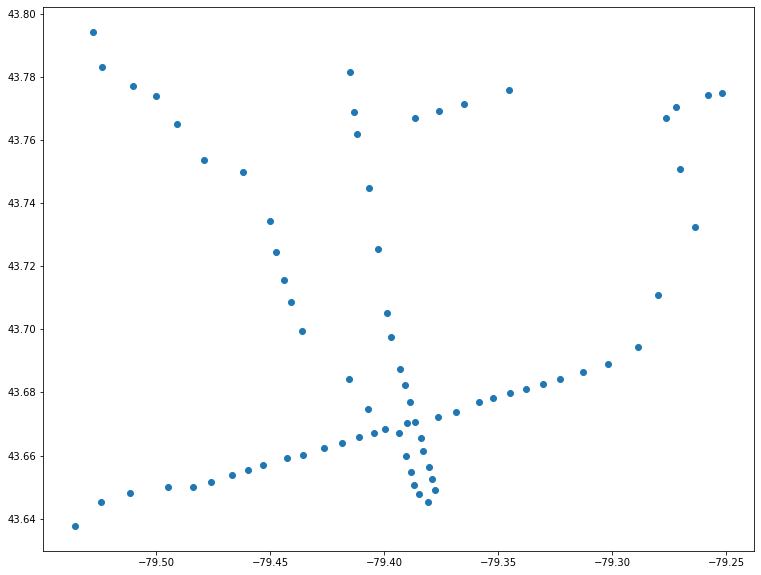

In [174]:
stations_point.plot()

In [175]:
px.scatter(stations_point, x='longitude', y='latitude',color='line', hover_data=['station'])

## Distance between consecutive stations and any stations

In [176]:
# convert to projected coordinate system
stations_point = stations_point.to_crs(epsg=epsg_2d)
distance = []
for line in stations_point.line.unique():
    # get distance between 2 consecutive stations within a subway line in km
    for i in range((stations_point[stations_point['line'] == line].shape[0])-1):
        distance.append((stations_point[stations_point['line'] == line].geometry.iloc[i].distance(stations_point[stations_point['line'] == line].geometry.iloc[i+1]))/10**3)

stations_point = stations_point.to_crs(epsg=epsg_3d)

In [177]:
# check distance calculation
i = 20
coords_1 = [stations_point['latitude'][i],stations_point['longitude'][i]]
coords_2 = [stations_point['latitude'][i+1],stations_point['longitude'][i+1]]

print(coords_1)
print(coords_2)
# google map shows 0.82644 km
print(distance[i], "km")
print(geopy.distance.distance(coords_1, coords_2).km, "km")

[43.6598804, -79.3904768]
[43.6670059, -79.3934342]
0.8266778209446685 km
0.8268393690333379 km


Distance between consecutive ttc stations
Average: 1.00 km
Minimum: 0.37 km between st andrew station and osgoode station
Median: 0.86 km between eglinton station and davisville station
Maximum: 2.73 km between victoria park station and warden station


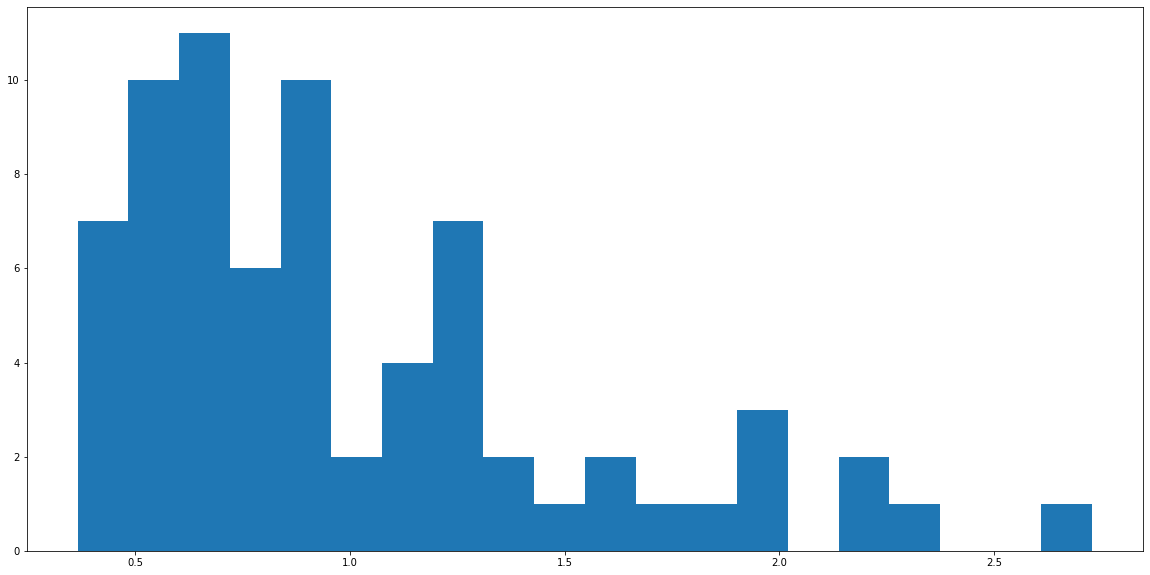

In [178]:
print("Distance between consecutive ttc stations")
plt.hist(distance, bins=20)
print(f"Average: {np.mean(distance):0.2f} km")
min_distance_loc = distance.index(np.min(distance))
print(f"Minimum: {np.min(distance):0.2f} km between {stations_point['station'][min_distance_loc]} station and {stations_point['station'][min_distance_loc+1]} station")
median_distance_loc = distance.index(np.median(distance))
print(f"Median: {np.median(distance):0.2f} km between {stations_point['station'][median_distance_loc]} station and {stations_point['station'][median_distance_loc+1]} station")
max_distance_loc = distance.index(np.max(distance))
print(f"Maximum: {np.max(distance):0.2f} km between {stations_point['station'][max_distance_loc]} station and {stations_point['station'][max_distance_loc+1]} station")


In [179]:
# since subway lines can overlap, there may be adjacent stations that are at a distance that is smaller  
# than the minimum distance between 2 consecutive stations

# convert to projected coordinate system
stations_point = stations_point.to_crs(epsg=epsg_2d)
min_distance = 5
for x in itertools.combinations(stations_point.index, 2):
    # get distance between any 2 stations
    all_distance = (stations_point.geometry.iloc[x[0]].distance(stations_point.geometry.iloc[x[1]]))/10**3
    if all_distance < min_distance:
        min_distance = all_distance
        min_a = stations_point.station.iloc[x[0]]
        min_b = stations_point.station.iloc[x[1]]

stations_point = stations_point.to_crs(epsg=epsg_3d)

print("Distance between any 2 ttc stations")
print(f"Minimum: {min_distance:0.2f} km between {min_a} station and {min_b} station")

Distance between any 2 ttc stations
Minimum: 0.28 km between bloor yonge station and bay station


## Define area around subway stations

In [180]:
# half of average distance between 2 stations
np.median(distance) / 2

0.43156720848624974

In [181]:
# define radius around each subway station in km
radius = 0.4 

def create_area(df, r):
    # convert radius in km to m
    # set resolution to 100 to mimic a circle
    return df.to_crs(epsg=epsg_2d).buffer(r*10**3, resolution=1000).to_crs(epsg=epsg_3d)


In [182]:
stations_point = stations_point.to_crs(epsg=epsg_2d)

# 64-sided polygon so not exactly a circle
print(f"Area of defined area around subway station: {(stations_point['geometry'].iloc[0].buffer(radius*10**3, resolution = 100).area)/10**6:0.4f} km^2")
# Check the area vs that of a circle
print(f"Check: {np.pi*radius**2:0.4f}")

stations_point = stations_point.to_crs(epsg=epsg_3d)

Area of defined area around subway station: 0.5026 km^2
Check: 0.5027


In [183]:
stations_area = stations_point.copy(deep=True)
stations_area['geometry'] = create_area(stations_point, radius)

stations_area.head()

,url,station,line,order,longitude,latitude,geometry
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781..."
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768..."
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761..."
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744..."
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725..."


Text(0.5, 1.0, 'Radius of 0.40km around subway stations')

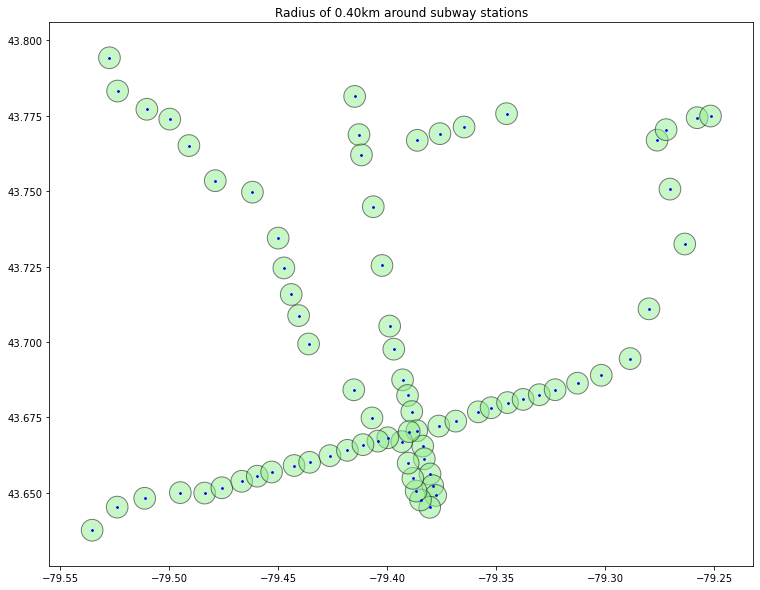

In [184]:
ax = stations_area.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
stations_point.plot(ax=ax, color = 'blue', markersize = 3)
plt.title(f'Radius of {radius:0.2f}km around subway stations')

In [185]:
# output files to clean_data folder
stations_point.to_file('./clean_data/stations_point.geojson', driver='GeoJSON')
stations_area.to_file('./clean_data/stations_area.geojson', driver='GeoJSON')

C:\Users\willi\anaconda3\envs\geospatial\lib\site-packages\geopandas\io\file.py:299: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



# Import Toronto major crime indicators
- About and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/about 
- crime csv file https://opendata.arcgis.com/api/v3/datasets/dc310b6a5b674f0bbdbead7b6dd572f0_0/downloads/data?format=csv&spatialRefId=3857 

In [186]:
mci_df = pd.read_csv('./raw_data/Major_Crime_Indicators.csv')
mci_df

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-8.854229e+06,5.425760e+06,1,GO-20141624853,D31,2014/03/02 05:00:00+00,2014/03/02 05:00:00+00,Apartment,1430,100,Assault,2014,March,2,61,Sunday,5,2014.0,March,2.0,61.0,Sunday,5,Assault,22,Humbermede,-79.538894,43.743025,1
1,-8.834951e+06,5.412259e+06,2,GO-20141625057,D51,2014/03/02 05:00:00+00,2014/03/02 05:00:00+00,Commercial,2120,200,B&E,2014,March,2,61,Sunday,7,2014.0,March,2.0,61.0,Sunday,4,Break and Enter,73,Moss Park,-79.365716,43.655340,2
2,-8.825836e+06,5.417935e+06,3,GO-20141259602,D41,2013/12/31 05:00:00+00,2014/01/01 05:00:00+00,Commercial,2120,220,B&E W'Intent,2014,January,1,1,Wednesday,0,2013.0,December,31.0,365.0,Tuesday,23,Break and Enter,121,Oakridge,-79.283837,43.692217,3
3,-8.847703e+06,5.416571e+06,4,GO-20141260128,D12,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,House,1430,100,Assault,2014,January,1,1,Wednesday,1,2014.0,January,1.0,1.0,Wednesday,1,Assault,111,Rockcliffe-Smythe,-79.480268,43.683360,4
4,-8.837275e+06,5.411569e+06,5,GO-20141259483,D52,2013/12/31 05:00:00+00,2014/01/01 05:00:00+00,Transit,1430,100,Assault,2014,January,1,1,Wednesday,1,2013.0,December,31.0,365.0,Tuesday,21,Assault,76,Bay Street Corridor,-79.386589,43.650853,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262702,-8.835231e+06,5.421552e+06,262198,GO-2021995584,D53,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,9,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.368232,43.715704,262703
262703,-8.849750e+06,5.417652e+06,262199,GO-2021994271,D12,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262704
262704,-8.849750e+06,5.417652e+06,262200,GO-2021994271,D12,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262705
262705,-8.834998e+06,5.421758e+06,262201,GO-2021994920,D53,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,5,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.366138,43.717042,262706


In [187]:
mci_df.dtypes

X                      float64
Y                      float64
Index_                   int64
event_unique_id         object
Division                object
occurrencedate          object
reporteddate            object
premisetype             object
ucr_code                 int64
ucr_ext                  int64
offence                 object
reportedyear             int64
reportedmonth           object
reportedday              int64
reporteddayofyear        int64
reporteddayofweek       object
reportedhour             int64
occurrenceyear         float64
occurrencemonth         object
occurrenceday          float64
occurrencedayofyear    float64
occurrencedayofweek     object
occurrencehour           int64
MCI                     object
Hood_ID                 object
Neighbourhood           object
Long                   float64
Lat                    float64
ObjectId                 int64
dtype: object

## Missing dates

In [188]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data


occurrenceyear         91
occurrencemonth        91
occurrenceday          91
occurrencedayofyear    91
occurrencedayofweek    91
dtype: int64

In [189]:
# print rows with missing data
na_index = mci_df.loc[mci_df.isna().any(axis=1)].index
mci_df.iloc[na_index]

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
55,-8.841593e+06,5.427986e+06,56,GO-20141262074,D32,1998/06/01 04:00:00+00,2014/01/01 05:00:00+00,Apartment,1480,110,Administering Noxious Thing,2014,January,1,1,Wednesday,12,NaN,NaN,NaN,NaN,NaN,12,Assault,38,Lansing-Westgate,-79.425384,43.757468,56
375,-8.834286e+06,5.433008e+06,376,GO-20141292170,D33,1996/01/31 05:00:00+00,2014/01/06 05:00:00+00,House,1430,100,Assault,2014,January,6,6,Monday,13,NaN,NaN,NaN,NaN,NaN,0,Assault,47,Don Valley Village,-79.359740,43.790041,376
2541,0.000000e+00,0.000000e+00,2642,GO-20141396749,D33,1980/01/01 05:00:00+00,2014/01/14 05:00:00+00,House,1420,100,Assault With Weapon,2014,January,14,14,Tuesday,14,NaN,NaN,NaN,NaN,NaN,12,Assault,NSA,NSA,0.000000,0.000000,2542
2542,0.000000e+00,0.000000e+00,2643,GO-20141396749,D33,1980/01/01 05:00:00+00,2014/01/14 05:00:00+00,House,1430,100,Assault,2014,January,14,14,Tuesday,14,NaN,NaN,NaN,NaN,NaN,12,Assault,NSA,NSA,0.000000,0.000000,2543
3673,-8.809009e+06,5.431450e+06,3074,GO-20141514632,D43,1999/10/01 04:00:00+00,2014/02/12 05:00:00+00,House,1410,100,Aggravated Assault,2014,February,12,43,Wednesday,8,NaN,NaN,NaN,NaN,NaN,12,Assault,131,Rouge,-79.132678,43.779935,3674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226172,-8.850984e+06,5.428447e+06,226643,GO-2021931130,D31,1999/12/20 05:00:00+00,2021/05/20 04:00:00+00,Apartment,1430,100,Assault,2021,May,20,140,Thursday,1,NaN,NaN,NaN,NaN,NaN,1,Assault,24,Black Creek,-79.509740,43.760460,226173
227601,-8.845608e+06,5.412716e+06,227221,GO-2021977404,D11,1994/09/01 04:00:00+00,2021/05/26 04:00:00+00,Educational,1430,100,Assault,2021,May,26,146,Wednesday,16,NaN,NaN,NaN,NaN,NaN,9,Assault,88,High Park North,-79.461451,43.658309,227602
230880,-8.850634e+06,5.425260e+06,230162,GO-20141947935,D31,1978/04/10 04:00:00+00,2014/04/24 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2014,April,24,114,Thursday,8,NaN,NaN,NaN,NaN,NaN,0,Auto Theft,25,Glenfield-Jane Heights,-79.506595,43.739776,230881
230881,-8.829596e+06,5.414344e+06,230163,GO-20161667005,D55,1996/01/01 05:00:00+00,2016/09/19 04:00:00+00,Other,2135,210,Theft Of Motor Vehicle,2016,September,19,263,Monday,13,NaN,NaN,NaN,NaN,NaN,0,Auto Theft,64,Woodbine Corridor,-79.317612,43.668890,230882


In [190]:
# we can use occurencedate to fill these na values
mci_df['occurrencedate'] = pd.to_datetime(mci_df['occurrencedate'])

def fix_na(col, series_replace):
    return np.where(mci_df[col].isna(), 
                    series_replace, # replace na with this value
                    mci_df[col])    # keep the non-na values

mci_df['occurrenceyear'] = fix_na('occurrenceyear',
                                  mci_df['occurrencedate'].dt.year.astype(float))
mci_df['occurrencemonth'] = fix_na('occurrencemonth',
                                   mci_df['occurrencedate'].dt.strftime("%B"))
mci_df['occurrenceday'] = fix_na('occurrenceday',
                                 mci_df['occurrencedate'].dt.day.astype(float))
mci_df['occurrencedayofyear'] = fix_na('occurrencedayofyear',
                                       mci_df['occurrencedate'].dt.dayofyear.astype(float))
mci_df['occurrencedayofweek'] = fix_na('occurrencedayofweek',
                                       mci_df['occurrencedate'].dt.strftime("%A"))

# rows with missing data are now filled with the correct entries
mci_df.iloc[na_index]

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
55,-8.841593e+06,5.427986e+06,56,GO-20141262074,D32,1998-06-01 04:00:00+00:00,2014/01/01 05:00:00+00,Apartment,1480,110,Administering Noxious Thing,2014,January,1,1,Wednesday,12,1998.0,June,1.0,152.0,Monday,12,Assault,38,Lansing-Westgate,-79.425384,43.757468,56
375,-8.834286e+06,5.433008e+06,376,GO-20141292170,D33,1996-01-31 05:00:00+00:00,2014/01/06 05:00:00+00,House,1430,100,Assault,2014,January,6,6,Monday,13,1996.0,January,31.0,31.0,Wednesday,0,Assault,47,Don Valley Village,-79.359740,43.790041,376
2541,0.000000e+00,0.000000e+00,2642,GO-20141396749,D33,1980-01-01 05:00:00+00:00,2014/01/14 05:00:00+00,House,1420,100,Assault With Weapon,2014,January,14,14,Tuesday,14,1980.0,January,1.0,1.0,Tuesday,12,Assault,NSA,NSA,0.000000,0.000000,2542
2542,0.000000e+00,0.000000e+00,2643,GO-20141396749,D33,1980-01-01 05:00:00+00:00,2014/01/14 05:00:00+00,House,1430,100,Assault,2014,January,14,14,Tuesday,14,1980.0,January,1.0,1.0,Tuesday,12,Assault,NSA,NSA,0.000000,0.000000,2543
3673,-8.809009e+06,5.431450e+06,3074,GO-20141514632,D43,1999-10-01 04:00:00+00:00,2014/02/12 05:00:00+00,House,1410,100,Aggravated Assault,2014,February,12,43,Wednesday,8,1999.0,October,1.0,274.0,Friday,12,Assault,131,Rouge,-79.132678,43.779935,3674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226172,-8.850984e+06,5.428447e+06,226643,GO-2021931130,D31,1999-12-20 05:00:00+00:00,2021/05/20 04:00:00+00,Apartment,1430,100,Assault,2021,May,20,140,Thursday,1,1999.0,December,20.0,354.0,Monday,1,Assault,24,Black Creek,-79.509740,43.760460,226173
227601,-8.845608e+06,5.412716e+06,227221,GO-2021977404,D11,1994-09-01 04:00:00+00:00,2021/05/26 04:00:00+00,Educational,1430,100,Assault,2021,May,26,146,Wednesday,16,1994.0,September,1.0,244.0,Thursday,9,Assault,88,High Park North,-79.461451,43.658309,227602
230880,-8.850634e+06,5.425260e+06,230162,GO-20141947935,D31,1978-04-10 04:00:00+00:00,2014/04/24 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2014,April,24,114,Thursday,8,1978.0,April,10.0,100.0,Monday,0,Auto Theft,25,Glenfield-Jane Heights,-79.506595,43.739776,230881
230881,-8.829596e+06,5.414344e+06,230163,GO-20161667005,D55,1996-01-01 05:00:00+00:00,2016/09/19 04:00:00+00,Other,2135,210,Theft Of Motor Vehicle,2016,September,19,263,Monday,13,1996.0,January,1.0,1.0,Monday,0,Auto Theft,64,Woodbine Corridor,-79.317612,43.668890,230882


In [191]:
print("Columns with missing data after filling na")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after filling na


Series([], dtype: int64)

## Imputing missing long and lat

array([[<AxesSubplot:title={'center':'Long'}>,
        <AxesSubplot:title={'center':'Lat'}>]], dtype=object)

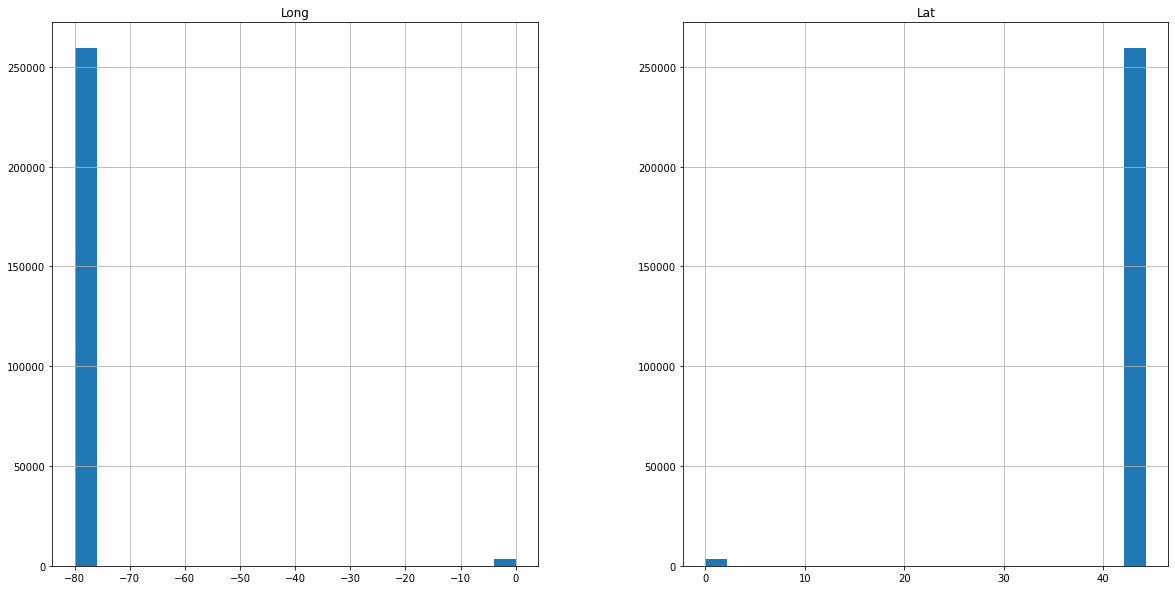

In [192]:
# missing long and lat values are stored as 0
mci_df[['Long','Lat']].hist(bins=20)

In [193]:
mci_df.loc[(mci_df['Long'] == 0) & (mci_df['Lat'] == 0), ["Neighbourhood", "Hood_ID"]].value_counts()

Neighbourhood                      Hood_ID
NSA                                NSA        3082
Wexford/Maryvale                   119          53
Yorkdale-Glen Park                 31           36
West Hill                          136          25
Bay Street Corridor                76           17
Bendale                            127          15
Glenfield-Jane Heights             25           13
York University Heights            27           12
Kennedy Park                       124           7
Mimico                             17            5
Tam OShanter-Sullivan              118           5
Victoria Village                   43            5
Pelmo Park-Humberlea               23            4
Newtonbrook East                   50            4
Bathurst Manor                     34            4
Highland Creek                     134           4
Downsview-Roding-CFB               26            3
Humber Summit                      21            3
Clairlea-Birchmount                120 

In [194]:
mci_df

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-8.854229e+06,5.425760e+06,1,GO-20141624853,D31,2014-03-02 05:00:00+00:00,2014/03/02 05:00:00+00,Apartment,1430,100,Assault,2014,March,2,61,Sunday,5,2014.0,March,2.0,61.0,Sunday,5,Assault,22,Humbermede,-79.538894,43.743025,1
1,-8.834951e+06,5.412259e+06,2,GO-20141625057,D51,2014-03-02 05:00:00+00:00,2014/03/02 05:00:00+00,Commercial,2120,200,B&E,2014,March,2,61,Sunday,7,2014.0,March,2.0,61.0,Sunday,4,Break and Enter,73,Moss Park,-79.365716,43.655340,2
2,-8.825836e+06,5.417935e+06,3,GO-20141259602,D41,2013-12-31 05:00:00+00:00,2014/01/01 05:00:00+00,Commercial,2120,220,B&E W'Intent,2014,January,1,1,Wednesday,0,2013.0,December,31.0,365.0,Tuesday,23,Break and Enter,121,Oakridge,-79.283837,43.692217,3
3,-8.847703e+06,5.416571e+06,4,GO-20141260128,D12,2014-01-01 05:00:00+00:00,2014/01/01 05:00:00+00,House,1430,100,Assault,2014,January,1,1,Wednesday,1,2014.0,January,1.0,1.0,Wednesday,1,Assault,111,Rockcliffe-Smythe,-79.480268,43.683360,4
4,-8.837275e+06,5.411569e+06,5,GO-20141259483,D52,2013-12-31 05:00:00+00:00,2014/01/01 05:00:00+00,Transit,1430,100,Assault,2014,January,1,1,Wednesday,1,2013.0,December,31.0,365.0,Tuesday,21,Assault,76,Bay Street Corridor,-79.386589,43.650853,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262702,-8.835231e+06,5.421552e+06,262198,GO-2021995584,D53,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,9,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.368232,43.715704,262703
262703,-8.849750e+06,5.417652e+06,262199,GO-2021994271,D12,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262704
262704,-8.849750e+06,5.417652e+06,262200,GO-2021994271,D12,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262705
262705,-8.834998e+06,5.421758e+06,262201,GO-2021994920,D53,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,5,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.366138,43.717042,262706


### Estimate with given neighborhood

In [195]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
mci_df = mci_df[~((mci_df['Long'] == 0) & (mci_df['Lat'] == 0) & (mci_df['Neighbourhood'] == "NSA"))].reset_index(drop=True)

In [196]:
missing_location = mci_df.loc[(mci_df['Long'] == 0) & (mci_df['Lat'] == 0)].index
mci_df.iloc[missing_location]

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
20920,0.0,0.0,21719,GO-20143049745,D53,2014-10-05 04:00:00+00:00,2014/10/05 04:00:00+00,Outside,1430,100,Assault,2014,October,5,278,Sunday,22,2014.0,October,5.0,278.0,Sunday,22,Assault,102,Forest Hill North,0.0,0.0,21220
27559,0.0,0.0,27419,GO-20143474848,D32,2014-12-12 05:00:00+00:00,2014/12/12 05:00:00+00,Outside,1610,200,Robbery - Mugging,2014,December,12,346,Friday,23,2014.0,December,12.0,346.0,Friday,23,Robbery,51,Willowdale East,0.0,0.0,27919
41789,0.0,0.0,42104,GO-20151057899,D22,2015-06-01 04:00:00+00:00,2015/06/23 04:00:00+00,Apartment,1420,100,Assault With Weapon,2015,June,23,174,Tuesday,19,2015.0,June,1.0,152.0,Monday,21,Assault,17,Mimico,0.0,0.0,42222
41791,0.0,0.0,42105,GO-20151057899,D22,2015-06-01 04:00:00+00:00,2015/06/23 04:00:00+00,Apartment,1430,100,Assault,2015,June,23,174,Tuesday,19,2015.0,June,1.0,152.0,Monday,21,Assault,17,Mimico,0.0,0.0,42224
77249,0.0,0.0,78206,GO-20161528344,D23,2016-08-28 04:00:00+00:00,2016/08/28 04:00:00+00,Outside,1430,100,Assault,2016,August,28,241,Sunday,23,2016.0,August,28.0,241.0,Sunday,12,Assault,21,Humber Summit,0.0,0.0,78020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255635,0.0,0.0,258264,GO-20201742672,D41,2020-09-14 04:00:00+00:00,2020/09/14 04:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2020,September,14,258,Monday,16,2020.0,September,14.0,258.0,Monday,2,Auto Theft,119,Wexford/Maryvale,0.0,0.0,258703
257451,0.0,0.0,260065,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021/01/01 05:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2021,January,1,1,Friday,16,2021.0,January,1.0,1.0,Friday,4,Auto Theft,43,Victoria Village,0.0,0.0,260522
257453,0.0,0.0,260066,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021/01/01 05:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2021,January,1,1,Friday,16,2021.0,January,1.0,1.0,Friday,4,Auto Theft,43,Victoria Village,0.0,0.0,260524
257594,0.0,0.0,260919,GO-2021413504,D22,2021-03-05 05:00:00+00:00,2021/03/05 05:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2021,March,5,64,Friday,18,2021.0,March,5.0,64.0,Friday,18,Auto Theft,17,Mimico,0.0,0.0,260665


In [197]:
missing_count = mci_df.iloc[missing_location]['Hood_ID'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'Hood_ID', 'Hood_ID':'count'})
missing_count

,Hood_ID,count
0,119,53
1,31,36
2,136,25
3,76,17
4,127,15
5,25,13
6,27,12
7,124,7
8,43,5
9,118,5


### Load neighborhood GeoJSON
- about https://data.torontopolice.on.ca/datasets/TorontoPS::neighbourhood-crime-rates-2020-1/about 
- Neighbourhood GeoJSON file https://opendata.arcgis.com/api/v3/datasets/3a1a9c98146e470e94e814b0e3a3fbca_0/downloads/data?format=geojson&spatialRefId=4326
- *Population figures reflect only the resident population of a region. The temporary population such as the commuters and business patrons are not included.

In [3]:
neighborhoods = gpd.read_file('./raw_data/Neighbourhood_Crime_Rates_2020.geojson')
neighborhoods.head()

ImportError: the 'read_file' function requires the 'fiona' package, but it is not installed or does not import correctly.
Importing fiona resulted in: DLL load failed while importing ogrext: The specified procedure could not be found.

In [199]:
# remove leading zeros in Hood_ID
neighborhoods['Hood_ID'] = neighborhoods['Hood_ID'].str.lstrip('0')

<AxesSubplot:>

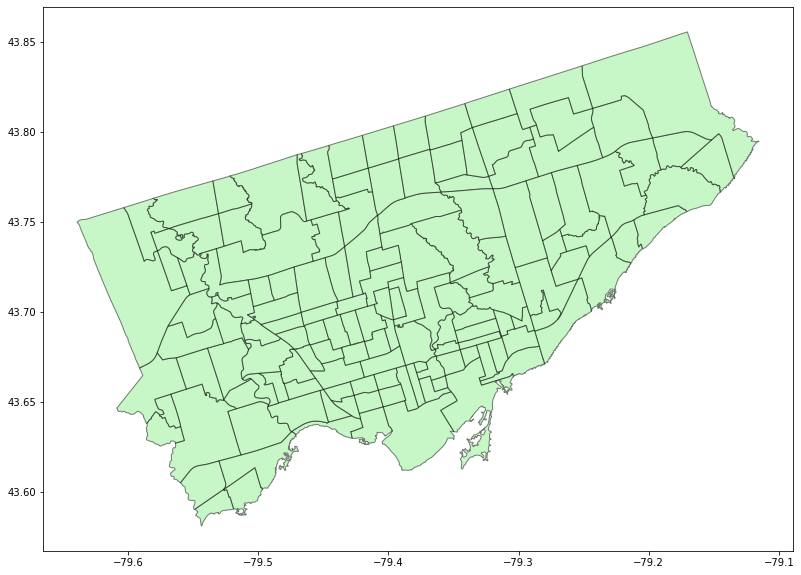

In [200]:
neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)


In [201]:
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Random locations within neighborhood

In [202]:
# randomly generate points within a defined neighborhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighborhood = neighborhoods.loc[neighborhoods['Hood_ID'] == str(hood_id)]
    polygon = selected_neighborhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.bounds.values.flatten().tolist()
    except ValueError:
        print(selected_neighborhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighborhood")
    return pd.Series([points_x, points_y])

12 points generated but only include the 10 points within the neighborhood


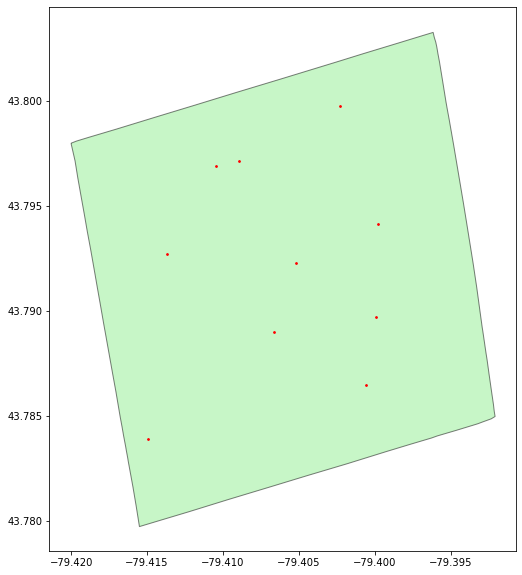

In [203]:
# select one hood_id to test
hood = 50
np.random.seed(123)
random_x, random_y = generate_random(10, hood)

# random points should lie within the neighborhood
# no red dots should be outside the neighborhood
ax = neighborhoods.loc[neighborhoods['Hood_ID'] == str(hood)]['geometry'].plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
plt.scatter(random_x, random_y, 
            color = 'red', s = 3)

In [204]:
np.random.seed(123)
missing_count[['Long', 'Lat']] = missing_count.apply(lambda x: generate_random(x['count'],x['Hood_ID']), axis=1)

70 points generated but only include the 53 points within the neighborhood
66 points generated but only include the 36 points within the neighborhood
42 points generated but only include the 25 points within the neighborhood
32 points generated but only include the 17 points within the neighborhood
22 points generated but only include the 15 points within the neighborhood
20 points generated but only include the 13 points within the neighborhood
18 points generated but only include the 12 points within the neighborhood
9 points generated but only include the 7 points within the neighborhood
7 points generated but only include the 5 points within the neighborhood
9 points generated but only include the 5 points within the neighborhood
8 points generated but only include the 5 points within the neighborhood
7 points generated but only include the 4 points within the neighborhood
10 points generated but only include the 4 points within the neighborhood
9 points generated but only include 

In [205]:
# random locations generated for each neighborhood with missing long and lat values
missing_count['len'] = missing_count['Long'].apply(lambda x: len(x))
missing_count

,Hood_ID,count,Long,Lat,len
0,119,53,"[-79.2905474645034, -79.31024017310659, -79.28...","[43.73845162529402, 43.75118356521948, 43.7450...",53
1,31,36,"[-79.4569641179742, -79.4484146065419, -79.466...","[43.722588866919466, 43.725195538263414, 43.72...",36
2,136,25,"[-79.17247756664437, -79.16873300409009, -79.1...","[43.75829731147847, 43.76188314701657, 43.7751...",25
3,76,17,"[-79.3837512293077, -79.38440980902507, -79.38...","[43.65404401527857, 43.64964469343091, 43.6502...",17
4,127,15,"[-79.25578936439268, -79.25033992847158, -79.2...","[43.753431143841475, 43.757729600347425, 43.74...",15
5,25,13,"[-79.50682850237801, -79.50238038884544, -79.5...","[43.73917913939486, 43.73652513135265, 43.7494...",13
6,27,12,"[-79.46898828337608, -79.49657018986852, -79.4...","[43.764745142230154, 43.756201350747354, 43.76...",12
7,124,7,"[-79.26753967137248, -79.25902272676625, -79.2...","[43.72598693702273, 43.73031281632378, 43.7321...",7
8,43,5,"[-79.31902003087431, -79.31054230854002, -79.3...","[43.72182427367543, 43.71611197128686, 43.7293...",5
9,118,5,"[-79.29023948997514, -79.29617293167792, -79.2...","[43.794858169895676, 43.790676936953375, 43.78...",5


In [206]:
# impute the missing long and lat values
for i in missing_count["Hood_ID"].unique():    
    index = (mci_df['Hood_ID'] == str(i)) & ((mci_df['Long'] == 0) | (mci_df['Lat'] == 0))
    # mci_df.loc[index, ['Long', 'Lat']] = 
    mci_df.loc[index, ['Long', 'Lat']] = pd.DataFrame([np.where(mci_df.loc[index, 'Long'] == 0, 
                                                                  missing_count[missing_count['Hood_ID'] == str(i)]['Long'].iloc[0],
                                                                  mci_df.loc[index, 'Long']),
                                                         np.where(mci_df.loc[index, 'Lat'] == 0, 
                                                                  missing_count[missing_count['Hood_ID'] == str(i)]['Lat'].iloc[0],
                                                                  mci_df.loc[index, 'Lat'])]).T.values

In [207]:
# check missing long and lat values are now imputed
mci_df.iloc[missing_location]

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
20920,0.0,0.0,21719,GO-20143049745,D53,2014-10-05 04:00:00+00:00,2014/10/05 04:00:00+00,Outside,1430,100,Assault,2014,October,5,278,Sunday,22,2014.0,October,5.0,278.0,Sunday,22,Assault,102,Forest Hill North,-79.439071,43.704104,21220
27559,0.0,0.0,27419,GO-20143474848,D32,2014-12-12 05:00:00+00:00,2014/12/12 05:00:00+00,Outside,1610,200,Robbery - Mugging,2014,December,12,346,Friday,23,2014.0,December,12.0,346.0,Friday,23,Robbery,51,Willowdale East,-79.407562,43.774186,27919
41789,0.0,0.0,42104,GO-20151057899,D22,2015-06-01 04:00:00+00:00,2015/06/23 04:00:00+00,Apartment,1420,100,Assault With Weapon,2015,June,23,174,Tuesday,19,2015.0,June,1.0,152.0,Monday,21,Assault,17,Mimico,-79.501777,43.615239,42222
41791,0.0,0.0,42105,GO-20151057899,D22,2015-06-01 04:00:00+00:00,2015/06/23 04:00:00+00,Apartment,1430,100,Assault,2015,June,23,174,Tuesday,19,2015.0,June,1.0,152.0,Monday,21,Assault,17,Mimico,-79.498076,43.615601,42224
77249,0.0,0.0,78206,GO-20161528344,D23,2016-08-28 04:00:00+00:00,2016/08/28 04:00:00+00,Outside,1430,100,Assault,2016,August,28,241,Sunday,23,2016.0,August,28.0,241.0,Sunday,12,Assault,21,Humber Summit,-79.556821,43.766467,78020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255635,0.0,0.0,258264,GO-20201742672,D41,2020-09-14 04:00:00+00:00,2020/09/14 04:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2020,September,14,258,Monday,16,2020.0,September,14.0,258.0,Monday,2,Auto Theft,119,Wexford/Maryvale,-79.300856,43.751013,258703
257451,0.0,0.0,260065,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021/01/01 05:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2021,January,1,1,Friday,16,2021.0,January,1.0,1.0,Friday,4,Auto Theft,43,Victoria Village,-79.305742,43.728405,260522
257453,0.0,0.0,260066,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021/01/01 05:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2021,January,1,1,Friday,16,2021.0,January,1.0,1.0,Friday,4,Auto Theft,43,Victoria Village,-79.317201,43.723712,260524
257594,0.0,0.0,260919,GO-2021413504,D22,2021-03-05 05:00:00+00:00,2021/03/05 05:00:00+00,Commercial,2135,210,Theft Of Motor Vehicle,2021,March,5,64,Friday,18,2021.0,March,5.0,64.0,Friday,18,Auto Theft,17,Mimico,-79.501599,43.621388,260665


### Add geometry for points

In [208]:
mci_df['geometry'] = mci_df.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)

In [209]:
# Documentation: The location of crime occurrences have been deliberately offset 
# to the nearest road intersection node 
# to protect the privacy of parties involved in the occurrence
mci_point = gpd.GeoDataFrame(mci_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

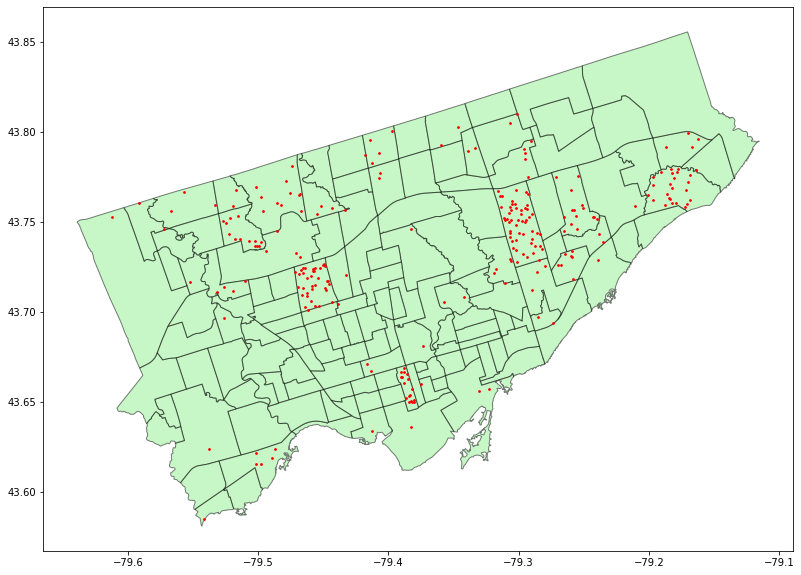

In [210]:
# show that random points generated to impute missing location are within the neighborhoods
# no red dots should be outside the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.iloc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

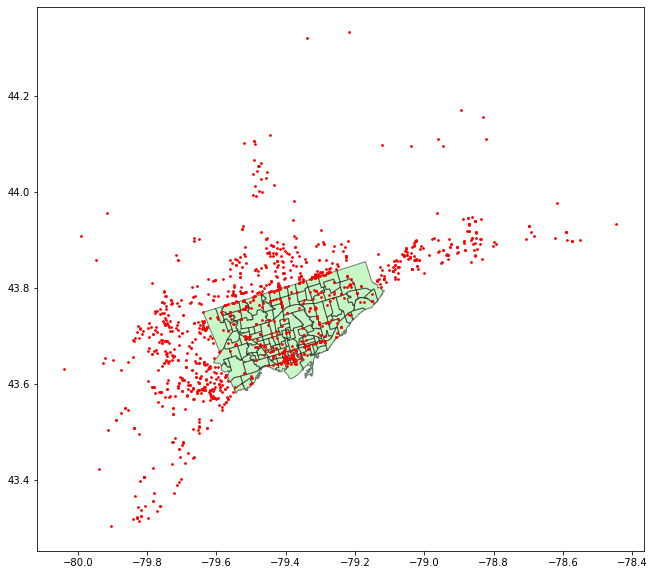

In [211]:
# some locations marked as NSA are actually within the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [212]:
# get the points contained within the neighborhoods
NSA_within_neighborhood = gpd.sjoin(mci_point[mci_point['Neighbourhood'] == 'NSA'], 
                                    neighborhoods, 
                                    op='intersects')
mci_point.loc[NSA_within_neighborhood.index, ['Hood_ID', 'Neighbourhood']] = NSA_within_neighborhood[['Hood_ID_right', 'Neighbourhood_right']].values

<AxesSubplot:>

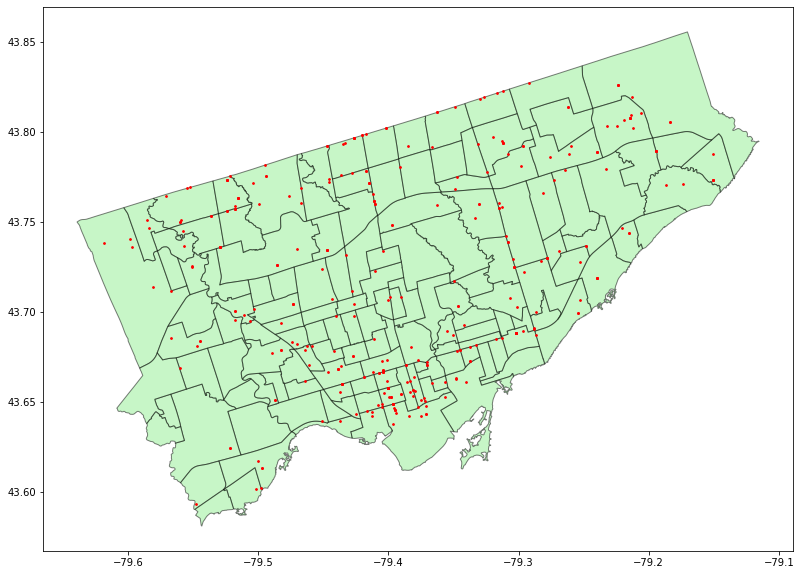

In [213]:
# check that we have correctly isolated only the locations within the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[NSA_within_neighborhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

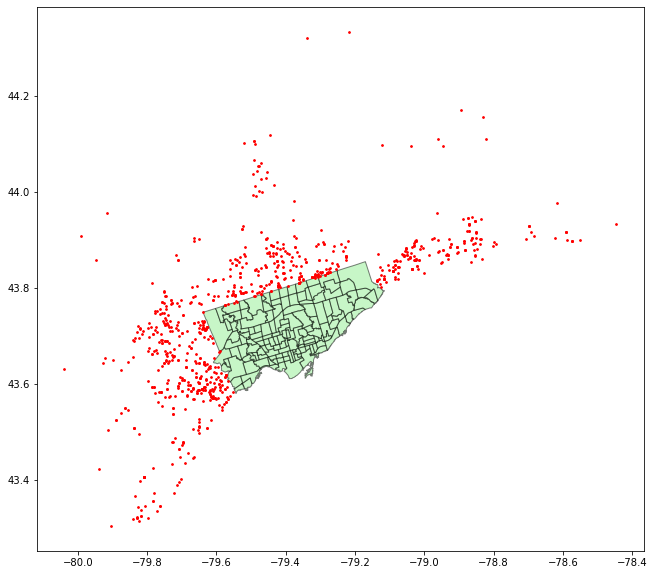

In [214]:
# check that now all the locations with neighborhood as NSA are outside any out the neighborhoods
# no red dots should be inside the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

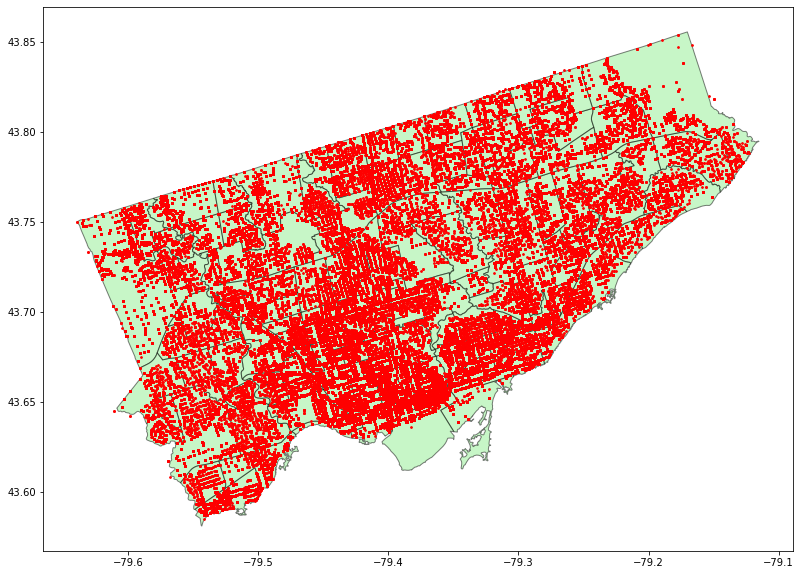

In [215]:
# now all the locations with neighborhood not as NSA are inside the neighborhoods
# no red dots should be outside the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [216]:
mci_point

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
0,-8.854229e+06,5.425760e+06,1,GO-20141624853,D31,2014-03-02 05:00:00+00:00,2014/03/02 05:00:00+00,Apartment,1430,100,Assault,2014,March,2,61,Sunday,5,2014.0,March,2.0,61.0,Sunday,5,Assault,22,Humbermede,-79.538894,43.743025,1,POINT (-79.53889 43.74302)
1,-8.834951e+06,5.412259e+06,2,GO-20141625057,D51,2014-03-02 05:00:00+00:00,2014/03/02 05:00:00+00,Commercial,2120,200,B&E,2014,March,2,61,Sunday,7,2014.0,March,2.0,61.0,Sunday,4,Break and Enter,73,Moss Park,-79.365716,43.655340,2,POINT (-79.36572 43.65534)
2,-8.825836e+06,5.417935e+06,3,GO-20141259602,D41,2013-12-31 05:00:00+00:00,2014/01/01 05:00:00+00,Commercial,2120,220,B&E W'Intent,2014,January,1,1,Wednesday,0,2013.0,December,31.0,365.0,Tuesday,23,Break and Enter,121,Oakridge,-79.283837,43.692217,3,POINT (-79.28384 43.69222)
3,-8.847703e+06,5.416571e+06,4,GO-20141260128,D12,2014-01-01 05:00:00+00:00,2014/01/01 05:00:00+00,House,1430,100,Assault,2014,January,1,1,Wednesday,1,2014.0,January,1.0,1.0,Wednesday,1,Assault,111,Rockcliffe-Smythe,-79.480268,43.683360,4,POINT (-79.48027 43.68336)
4,-8.837275e+06,5.411569e+06,5,GO-20141259483,D52,2013-12-31 05:00:00+00:00,2014/01/01 05:00:00+00,Transit,1430,100,Assault,2014,January,1,1,Wednesday,1,2013.0,December,31.0,365.0,Tuesday,21,Assault,76,Bay Street Corridor,-79.386589,43.650853,5,POINT (-79.38659 43.65085)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259618,-8.835231e+06,5.421552e+06,262198,GO-2021995584,D53,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,9,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.368232,43.715704,262703,POINT (-79.36823 43.71570)
259619,-8.849750e+06,5.417652e+06,262199,GO-2021994271,D12,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262704,POINT (-79.49865 43.69038)
259620,-8.849750e+06,5.417652e+06,262200,GO-2021994271,D12,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262705,POINT (-79.49865 43.69038)
259621,-8.834998e+06,5.421758e+06,262201,GO-2021994920,D53,2021-05-29 04:00:00+00:00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,5,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.366138,43.717042,262706,POINT (-79.36614 43.71704)


In [217]:
# output file to clean_data folder
# csv instead of geojson due to size
mci_point.to_csv('./clean_data/mci_point.csv', index=False)

In [218]:
neighbourhood_count = pd.DataFrame(mci_point["Hood_ID"].value_counts())
neighbourhood_count = neighbourhood_count.reset_index().rename(columns = {'index': 'Hood_ID', 'Hood_ID': 'count'})
neighbourhood_count

,Hood_ID,count
0,77,9645
1,75,8563
2,76,7619
3,1,6939
4,73,6382
...,...,...
136,140,496
137,97,486
138,60,473
139,29,472


In [219]:
neighborhoods_density = neighborhoods.merge(neighbourhood_count, on = 'Hood_ID')
neighborhoods_density['Density_By_Area'] = neighborhoods_density['count'] / neighborhoods_density.to_crs(epsg_2d)['geometry'].area
neighborhoods_density['Density_By_Population'] = neighborhoods_density['count'] / neighborhoods_density['F2020_Population_Projection']

<AxesSubplot:>

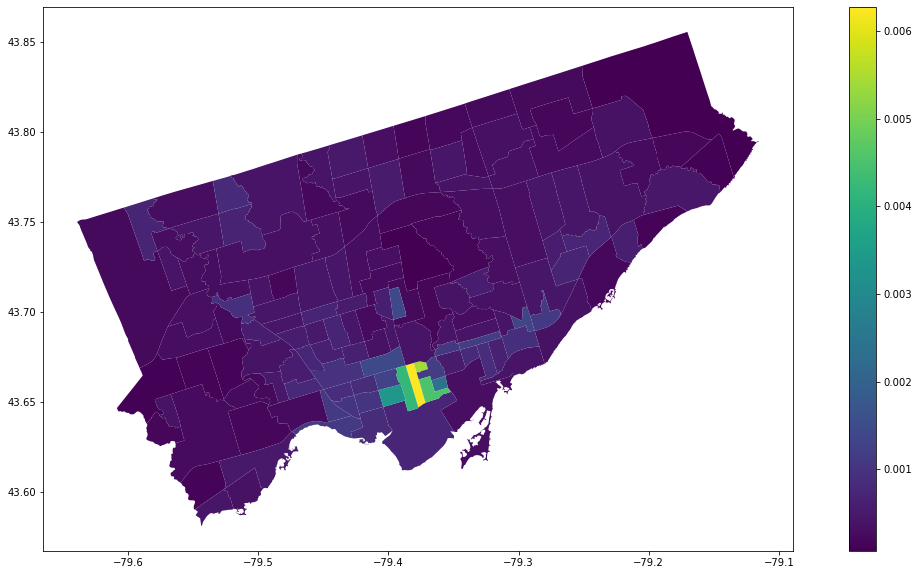

In [220]:
neighborhoods_density.plot(column = 'Density_By_Area', cmap = 'viridis', legend = True)

<AxesSubplot:>

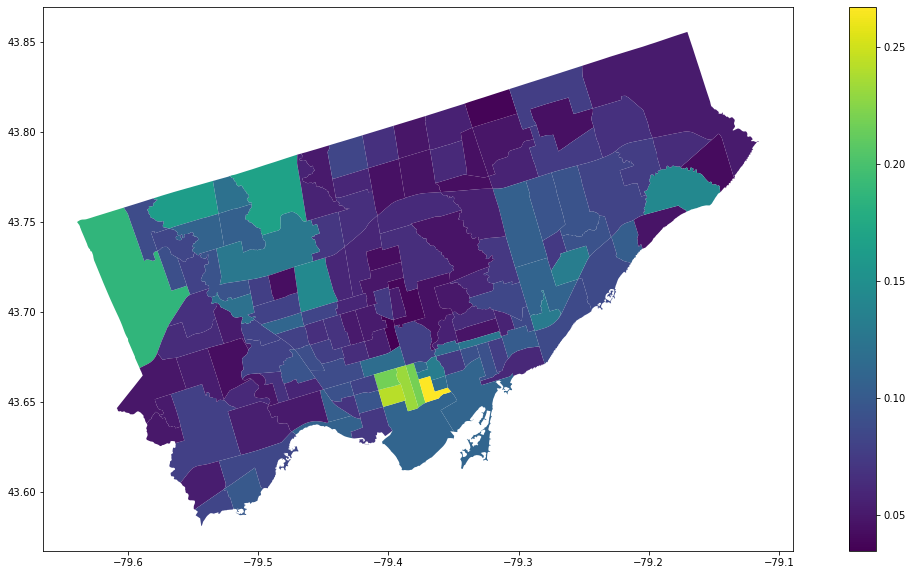

In [221]:
neighborhoods_density.plot(column = 'Density_By_Population', cmap = 'viridis', legend = True)

In [222]:
px.scatter(neighborhoods_density, x = 'Density_By_Area', y = 'Density_By_Population', color = 'Neighbourhood', size = 'count', size_max = 50)

# Import traffic collisions data
- Traffic Collisions https://opendata.arcgis.com/api/v3/datasets/2a36d61277a84c3eb9d0beebef4c023d_0/downloads/data?format=csv&spatialRefId=3857

In [223]:
collision_df = pd.read_csv('./raw_data/Traffic_Collisions.csv')
collision_df

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Longitude,Latitude,ObjectId2
0,0.000000e+00,0.000000e+00,1,GO-20141001,2014/02/07 05:00:00+00,February,Friday,2014,16,NSA,NSA,NSA,0,NO,NO,YES,0.000000,0.000000,1
1,0.000000e+00,0.000000e+00,2,GO-20141225593,2014/01/02 05:00:00+00,January,Thursday,2014,3,NSA,NSA,NSA,0,NO,YES,NO,0.000000,0.000000,2
2,0.000000e+00,0.000000e+00,3,GO-20141260499,2014/01/01 05:00:00+00,January,Wednesday,2014,2,NSA,NSA,NSA,0,YES,NO,NO,0.000000,0.000000,3
3,0.000000e+00,0.000000e+00,4,GO-20141260663,2014/01/01 05:00:00+00,January,Wednesday,2014,3,NSA,NSA,NSA,0,NO,NO,YES,0.000000,0.000000,4
4,0.000000e+00,0.000000e+00,5,GO-20141261162,2014/01/01 05:00:00+00,January,Wednesday,2014,5,NSA,NSA,NSA,0,YES,NO,NO,0.000000,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499533,-8.865398e+06,5.426816e+06,499212,GO-20178006796,2017/02/14 05:00:00+00,February,Tuesday,2017,14,NSA,NSA,NSA,0,NO,NO,YES,-79.639225,43.749873,499534
499534,-8.865398e+06,5.426816e+06,499213,GO-20178007507,2017/02/18 05:00:00+00,February,Saturday,2017,13,NSA,NSA,NSA,0,NO,YES,NO,-79.639225,43.749873,499535
499535,-8.865398e+06,5.426816e+06,499214,GO-20178008123,2017/02/22 05:00:00+00,February,Wednesday,2017,22,D23,1,West Humber-Clairville (1),0,NO,NO,YES,-79.639225,43.749873,499536
499536,-8.865398e+06,5.426816e+06,499215,GO-20178014940,2017/04/07 04:00:00+00,April,Friday,2017,14,NSA,NSA,NSA,0,NO,NO,YES,-79.639225,43.749873,499537


In [224]:
collision_df.shape

(499538, 19)

In [225]:
print("Columns with missing data")
collision_df.isna().sum()[collision_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

In [226]:
collision_df.describe()

,X,Y,OBJECTID,Year,Hour,Fatalities,Longitude,Latitude,ObjectId2
count,4.995380e+05,4.995380e+05,499538.000000,499538.000000,499538.000000,499538.000000,499538.000000,499538.000000,499538.000000
mean,-7.608867e+06,4.667592e+06,249769.500000,2017.098963,13.474358,0.000879,-68.351612,37.636255,249769.500000
std,3.058109e+06,1.875977e+06,144204.343722,2.001601,4.921921,0.029968,27.471464,15.126536,144204.343722
min,-8.910434e+06,0.000000e+00,1.000000,2014.000000,0.000000,0.000000,-80.043789,0.000000,1.000000
25%,-8.844124e+06,5.411227e+06,124885.250000,2015.000000,10.000000,0.000000,-79.448115,43.648629,124885.250000
50%,-8.836164e+06,5.418897e+06,249769.500000,2017.000000,14.000000,0.000000,-79.376608,43.698464,249769.500000
75%,-8.824426e+06,5.427873e+06,374653.750000,2019.000000,17.000000,0.000000,-79.271170,43.756733,374653.750000
max,0.000000e+00,5.533134e+06,499538.000000,2021.000000,23.000000,3.000000,0.000000,44.435809,499538.000000


## Extract Hood_ID from neighbourhood

In [227]:
collision_df[['Neighbourhood', 'Hood_ID']] = collision_df['Neighbourhood'].str.split('(', 1, expand=True)
collision_df['Hood_ID'] = collision_df['Hood_ID'].str.split(')', 1, expand=True).iloc[:,0].fillna('NSA')

In [228]:
# check that every NSA in Hood_ID is NSA in neighbourhood
# should only show "NSA" as the only unique entry
collision_df[collision_df['Hood_ID'] == "NSA"]['Neighbourhood'].unique()

array(['NSA'], dtype=object)

In [229]:
collision_df.rename(columns={'Longitude': 'Long', 'Latitude': 'Lat'}, inplace=True)
collision_df

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Long,Lat,ObjectId2,Hood_ID
0,0.000000e+00,0.000000e+00,1,GO-20141001,2014/02/07 05:00:00+00,February,Friday,2014,16,NSA,NSA,NSA,0,NO,NO,YES,0.000000,0.000000,1,NSA
1,0.000000e+00,0.000000e+00,2,GO-20141225593,2014/01/02 05:00:00+00,January,Thursday,2014,3,NSA,NSA,NSA,0,NO,YES,NO,0.000000,0.000000,2,NSA
2,0.000000e+00,0.000000e+00,3,GO-20141260499,2014/01/01 05:00:00+00,January,Wednesday,2014,2,NSA,NSA,NSA,0,YES,NO,NO,0.000000,0.000000,3,NSA
3,0.000000e+00,0.000000e+00,4,GO-20141260663,2014/01/01 05:00:00+00,January,Wednesday,2014,3,NSA,NSA,NSA,0,NO,NO,YES,0.000000,0.000000,4,NSA
4,0.000000e+00,0.000000e+00,5,GO-20141261162,2014/01/01 05:00:00+00,January,Wednesday,2014,5,NSA,NSA,NSA,0,YES,NO,NO,0.000000,0.000000,5,NSA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499533,-8.865398e+06,5.426816e+06,499212,GO-20178006796,2017/02/14 05:00:00+00,February,Tuesday,2017,14,NSA,NSA,NSA,0,NO,NO,YES,-79.639225,43.749873,499534,NSA
499534,-8.865398e+06,5.426816e+06,499213,GO-20178007507,2017/02/18 05:00:00+00,February,Saturday,2017,13,NSA,NSA,NSA,0,NO,YES,NO,-79.639225,43.749873,499535,NSA
499535,-8.865398e+06,5.426816e+06,499214,GO-20178008123,2017/02/22 05:00:00+00,February,Wednesday,2017,22,D23,1,West Humber-Clairville,0,NO,NO,YES,-79.639225,43.749873,499536,1
499536,-8.865398e+06,5.426816e+06,499215,GO-20178014940,2017/04/07 04:00:00+00,April,Friday,2017,14,NSA,NSA,NSA,0,NO,NO,YES,-79.639225,43.749873,499537,NSA


## Impute missing long and lat

In [230]:
collision_df.loc[(collision_df['Long'] == 0) & (collision_df['Lat'] == 0), ["Neighbourhood"]].value_counts()

Neighbourhood                
NSA                              69252
Wexford/Maryvale                    64
West Hill                           26
Kennedy Park                        15
Yorkdale-Glen Park                  13
Hillcrest Village                   12
LAmoreaux                           11
Glenfield-Jane Heights               8
Clairlea-Birchmount                  8
York University Heights              7
Bendale                              7
Highland Creek                       5
Agincourt South-Malvern West         5
Black Creek                          5
Islington-City Centre West           4
Bay Street Corridor                  3
Bayview Woods-Steeles                3
Bathurst Manor                       2
Church-Yonge Corridor                2
Westminster-Branson                  2
West Humber-Clairville               2
Pelmo Park-Humberlea                 2
St.Andrew-Windfields                 1
Woburn                               1
Bedford Park-Nortown              

In [231]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
collision_df = collision_df[~((collision_df['Long'] == 0) & (collision_df['Lat'] == 0) & (collision_df['Neighbourhood'] == "NSA"))].reset_index(drop=True)

In [232]:
missing_location = collision_df.loc[(collision_df['Long'] == 0) & (collision_df['Lat'] == 0)].index
collision_df.iloc[missing_location]

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Long,Lat,ObjectId2,Hood_ID
0,0.0,0.0,278,GO-20141591056,2014/02/24 05:00:00+00,February,Monday,2014,17,D32,40,St.Andrew-Windfields,0,NO,YES,NO,0.0,0.0,178,40
1,0.0,0.0,1246,GO-20143120578,2014/10/17 04:00:00+00,October,Friday,2014,9,D31,25,Glenfield-Jane Heights,0,NO,NO,YES,0.0,0.0,1046,25
2,0.0,0.0,21564,GO-20168056919,2016/12/17 05:00:00+00,December,Saturday,2016,9,D31,27,York University Heights,0,NO,NO,YES,0.0,0.0,21094,27
3,0.0,0.0,21709,GO-20168059092,2016/12/27 05:00:00+00,December,Tuesday,2016,18,D32,31,Yorkdale-Glen Park,0,NO,YES,NO,0.0,0.0,21162,31
4,0.0,0.0,21277,GO-20168053844,2016/11/30 05:00:00+00,November,Wednesday,2016,18,D33,48,Hillcrest Village,0,NO,NO,YES,0.0,0.0,21340,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0.0,0.0,69463,GO-20198030463,2019/05/20 04:00:00+00,May,Monday,2019,8,D43,103,Lawrence Park South,0,YES,NO,NO,0.0,0.0,69919,103
714,0.0,0.0,69464,GO-20198076663,2019/12/21 05:00:00+00,December,Saturday,2019,12,D42,1,West Humber-Clairville,0,NO,NO,YES,0.0,0.0,69921,1
715,0.0,0.0,69465,GO-20201700319,2020/09/08 04:00:00+00,September,Tuesday,2020,15,D33,45,Parkwoods-Donalda,0,NO,YES,YES,0.0,0.0,69923,45
716,0.0,0.0,69466,GO-20208029200,2020/09/30 04:00:00+00,September,Wednesday,2020,15,D32,105,Lawrence Park North,0,NO,NO,YES,0.0,0.0,69925,105


In [233]:
missing_count = collision_df.iloc[missing_location]['Hood_ID'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'Hood_ID', 'Hood_ID':'count'})
missing_count

,Hood_ID,count
0,119,64
1,136,26
2,124,15
3,31,13
4,48,12
5,117,11
6,25,8
7,120,8
8,27,7
9,127,7


In [234]:
np.random.seed(123)
missing_count[['Long', 'Lat']] = missing_count.apply(lambda x: generate_random(x['count'],x['Hood_ID']), axis=1)

86 points generated but only include the 64 points within the neighborhood
49 points generated but only include the 26 points within the neighborhood
34 points generated but only include the 15 points within the neighborhood
15 points generated but only include the 13 points within the neighborhood
17 points generated but only include the 12 points within the neighborhood
29 points generated but only include the 11 points within the neighborhood
10 points generated but only include the 8 points within the neighborhood
19 points generated but only include the 8 points within the neighborhood
12 points generated but only include the 7 points within the neighborhood
7 points generated but only include the 7 points within the neighborhood
10 points generated but only include the 5 points within the neighborhood
10 points generated but only include the 5 points within the neighborhood
7 points generated but only include the 5 points within the neighborhood
10 points generated but only inclu

In [235]:
# random locations generated for each neighborhood with missing long and lat values
missing_count['len'] = missing_count['Long'].apply(lambda x: len(x))
missing_count

,Hood_ID,count,Long,Lat,len
0,119,64,"[-79.2905474645034, -79.31024017310659, -79.28...","[43.73845162529402, 43.75118356521948, 43.7450...",64
1,136,26,"[-79.19911824880309, -79.18040350946745, -79.1...","[43.75765197946631, 43.76546946821289, 43.7572...",26
2,124,15,"[-79.26654982146835, -79.27463062049003, -79.2...","[43.72232249578001, 43.7224000798009, 43.71780...",15
3,31,13,"[-79.45996226267624, -79.46065952752981, -79.4...","[43.707040006978474, 43.71897347621641, 43.705...",13
4,48,12,"[-79.3520875268021, -79.33868359752705, -79.36...","[43.80780466875634, 43.80490053510152, 43.8091...",12
5,117,11,"[-79.30228548159286, -79.29101438573844, -79.3...","[43.79210334082548, 43.796763995859656, 43.796...",11
6,25,8,"[-79.51354369472986, -79.51079945917418, -79.5...","[43.74301390592894, 43.756067443593345, 43.739...",8
7,120,8,"[-79.29825934015967, -79.28250707547197, -79.2...","[43.717965362775196, 43.7212468235057, 43.7092...",8
8,27,7,"[-79.49825254767276, -79.48530259746411, -79.4...","[43.76390670967839, 43.7606371871618, 43.76592...",7
9,127,7,"[-79.25473825213193, -79.26135086018229, -79.2...","[43.77002794299879, 43.77322670528096, 43.7432...",7


In [236]:
# impute the missing long and lat values
for i in missing_count["Hood_ID"].unique():    
    index = (collision_df['Hood_ID'] == str(i)) & ((collision_df['Long'] == 0) | (mci_df['Lat'] == 0))
    collision_df.loc[index, ['Long', 'Lat']] = pd.DataFrame([np.where(collision_df.loc[index, 'Long'] == 0, 
                                                                      missing_count[missing_count['Hood_ID'] == str(i)]['Long'].iloc[0],
                                                                      collision_df.loc[index, 'Long']),
                                                             np.where(collision_df.loc[index, 'Lat'] == 0, 
                                                                      missing_count[missing_count['Hood_ID'] == str(i)]['Lat'].iloc[0],
                                                                      collision_df.loc[index, 'Lat'])]).T.values

In [237]:
# check missing long and lat values are now imputed
collision_df.iloc[missing_location]

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Long,Lat,ObjectId2,Hood_ID
0,0.0,0.0,278,GO-20141591056,2014/02/24 05:00:00+00,February,Monday,2014,17,D32,40,St.Andrew-Windfields,0,NO,YES,NO,-79.402034,43.748097,178,40
1,0.0,0.0,1246,GO-20143120578,2014/10/17 04:00:00+00,October,Friday,2014,9,D31,25,Glenfield-Jane Heights,0,NO,NO,YES,-79.513544,43.743014,1046,25
2,0.0,0.0,21564,GO-20168056919,2016/12/17 05:00:00+00,December,Saturday,2016,9,D31,27,York University Heights,0,NO,NO,YES,-79.498253,43.763907,21094,27
3,0.0,0.0,21709,GO-20168059092,2016/12/27 05:00:00+00,December,Tuesday,2016,18,D32,31,Yorkdale-Glen Park,0,NO,YES,NO,-79.459962,43.707040,21162,31
4,0.0,0.0,21277,GO-20168053844,2016/11/30 05:00:00+00,November,Wednesday,2016,18,D33,48,Hillcrest Village,0,NO,NO,YES,-79.352088,43.807805,21340,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0.0,0.0,69463,GO-20198030463,2019/05/20 04:00:00+00,May,Monday,2019,8,D43,103,Lawrence Park South,0,YES,NO,NO,-79.412967,43.714967,69919,103
714,0.0,0.0,69464,GO-20198076663,2019/12/21 05:00:00+00,December,Saturday,2019,12,D42,1,West Humber-Clairville,0,NO,NO,YES,-79.616253,43.752839,69921,1
715,0.0,0.0,69465,GO-20201700319,2020/09/08 04:00:00+00,September,Tuesday,2020,15,D33,45,Parkwoods-Donalda,0,NO,YES,YES,-79.342754,43.761909,69923,45
716,0.0,0.0,69466,GO-20208029200,2020/09/30 04:00:00+00,September,Wednesday,2020,15,D32,105,Lawrence Park North,0,NO,NO,YES,-79.415767,43.732380,69925,105


### Add geometry points

In [238]:
collision_df['geometry'] = collision_df.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)

In [239]:
collision_point = gpd.GeoDataFrame(collision_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

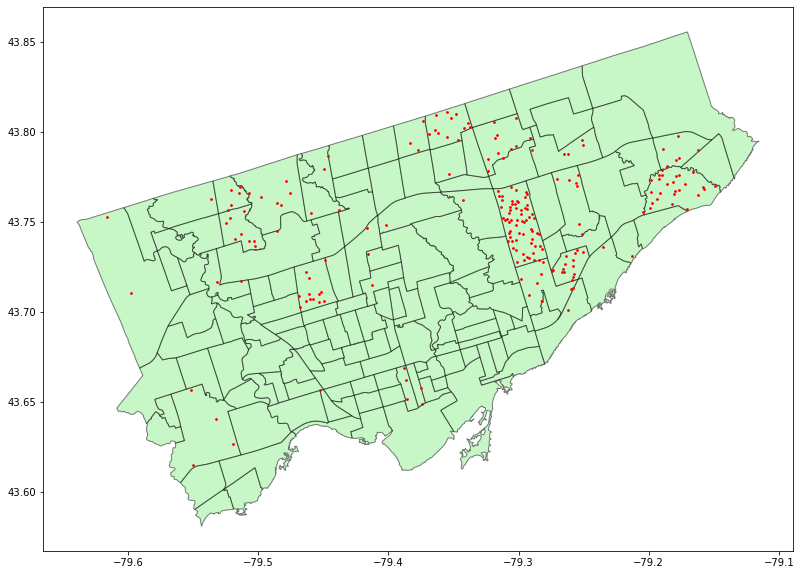

In [240]:
# show that random points generated to impute missing location are within the neighborhoods
# no red dots should be outside the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.iloc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

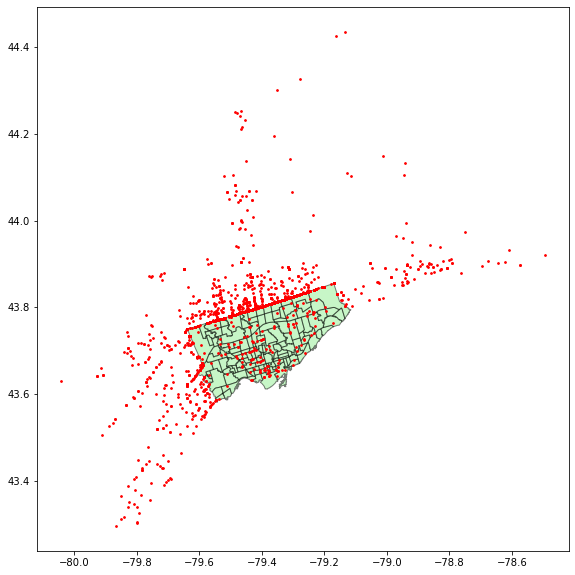

In [241]:
# some locations marked as NSA are actually within the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [242]:
# get the points contained within the neighborhood
NSA_within_neighborhood = gpd.sjoin(collision_point[collision_point['Neighbourhood'] == 'NSA'], 
                                    neighborhoods, 
                                    op='intersects')
collision_point.loc[NSA_within_neighborhood.index, ['Hood_ID', 'Neighbourhood']] = NSA_within_neighborhood[['Hood_ID_right', 'Neighbourhood_right']].values

<AxesSubplot:>

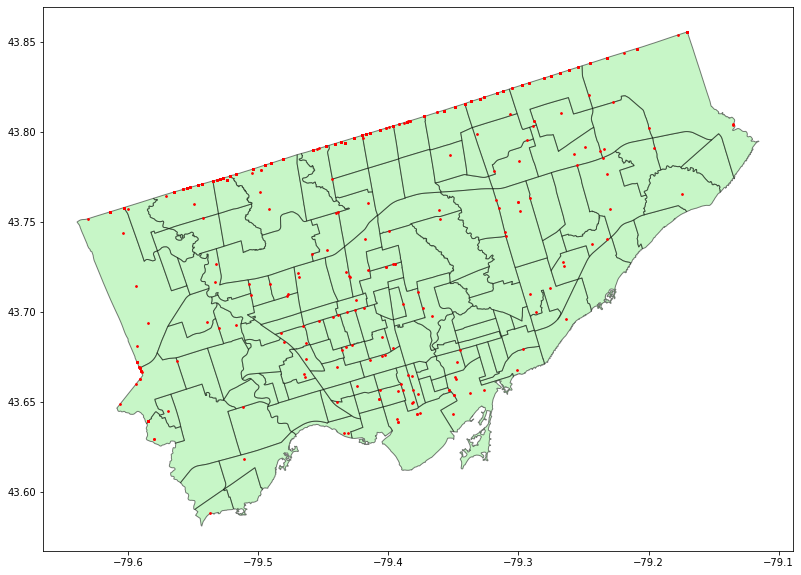

In [243]:
# check that we have correctly isolated only the locations within the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[NSA_within_neighborhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

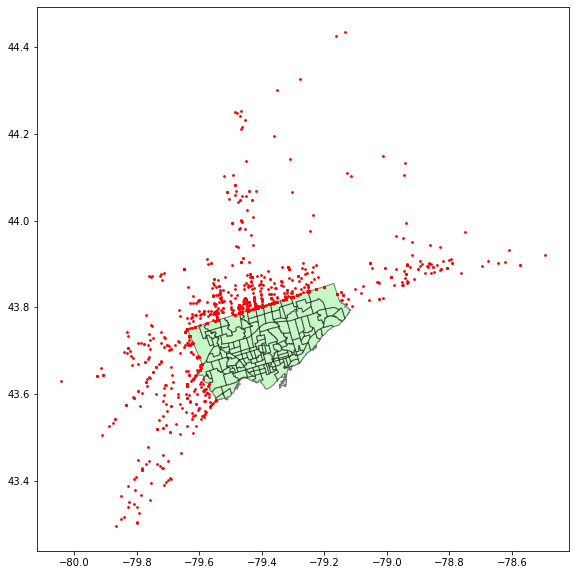

In [244]:
# check that now all the locations with neighborhood as NSA are outside any out the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

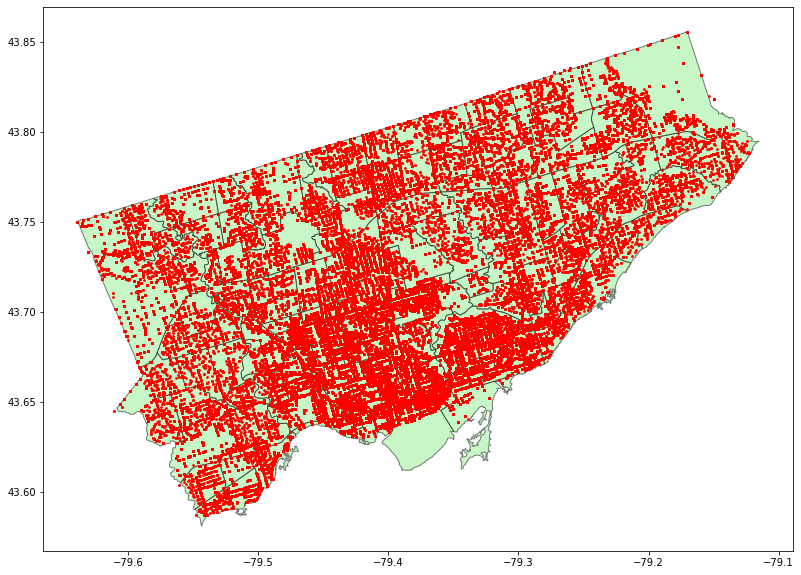

In [245]:
# now all the locations with neighborhood not as NSA are inside the neighborhoods
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [246]:
# output file to clean_data folder
# csv instead of geojson due to size
collision_point.to_csv('./clean_data/collision_point.csv', index=False)

# Find rental data
- Reference for getting data from zumper: https://medium.com/@backupfairuz/exploring-rental-rates-in-canada-hands-on-project-making-use-of-foursquare-api-with-python-413793d2dfca

In [247]:
# Improvement
# bungol.ca for data of housing transaction prices (not listing like other websites)
# real transaction data instead of listings
# access to paid APIs https://rapidapi.com/blog/best-real-estate-apis/

# Commute time / distance

In [248]:
# from subway stations to University of Toronto - St George Campus
destination = [43.6627738123847, -79.39578019941028]
commute_time = ['46 min',
                '41 min',
                '40 min',
                '37 min',
                '34 min',
                '30 min',
                '28 min',
                '26 min',
                '25 min',
                '23 min',
                '14 min',
                '13 min',
                '11 min',
                '10 min',
                '16 min',
                '14 min',
                '12 min',
                '11 min',
                '10 min',
                '9 min',
                '6 min',
                '9 min',
                '10 min',
                '12 min',
                '13 min',
                '26 min',
                '21 min',
                '22 min',
                '23 min',
                '25 min',
                '28 min',
                '31 min',
                '34 min',
                '36 min',
                '38 min',
                '41 min',
                '43 min',
                '44 min',
                '33 min',
                '31 min',
                '29 min',
                '27 min',
                '25 min',
                '24 min',
                '23 min',
                '21 min',
                '22 min',
                '19 min',
                '18 min',
                '16 min',
                '15 min',
                '7 min',
                '13 min',
                '5 min',
                '21 min',
                '18 min',
                '19 min',
                '21 min',
                '22 min',
                '35 min',
                '24 min',
                '25 min',
                '27 min',
                '29 min',
                '32 min',
                '36 min',
                '48 min',
                '48 min',
                '49 min',
                '51 min',
                '52 min',
                '48 min',
                '49 min',
                '58 min',
                '52 min']

In [249]:
commute_time = [int(re.search(r'\d+', x).group()) for x in commute_time]

In [250]:
stations_area['commute_time'] = commute_time

In [251]:
stations_area

,url,station,line,order,longitude,latitude,geometry,commute_time
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781...",46
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768...",41
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761...",40
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744...",37
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725...",34
...,...,...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,"POLYGON ((-79.24685 43.77486, -79.24685 43.774...",52
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,"POLYGON ((-79.38134 43.76680, -79.38134 43.766...",48
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,"POLYGON ((-79.37094 43.76902, -79.37094 43.769...",49
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296,"POLYGON ((-79.35987 43.77122, -79.35987 43.771...",58


<AxesSubplot:>

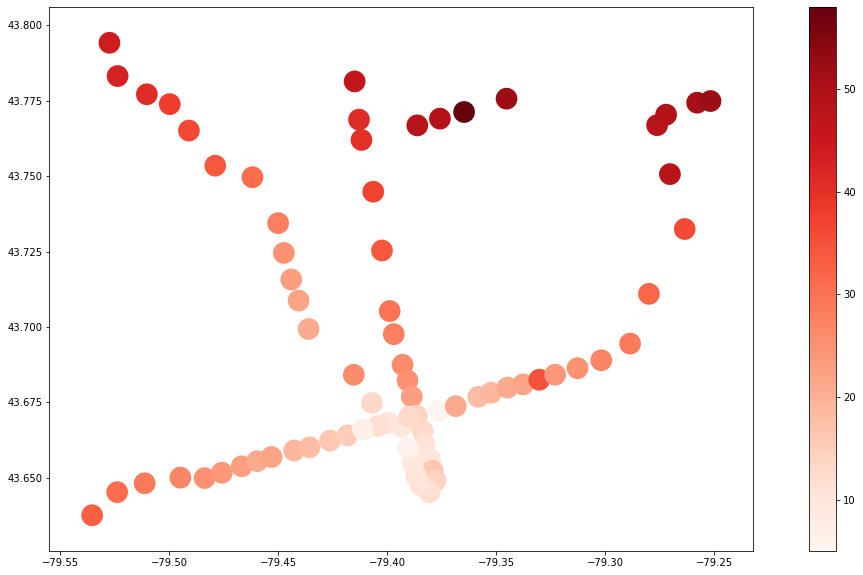

In [252]:
stations_area.plot(column = 'commute_time', cmap = 'Reds', legend = True)

In [253]:
px.scatter(stations_area, x = 'longitude', y = 'latitude', color = 'station', size = 'commute_time')

In [254]:
# stations_point['destination'] = shapely.geometry.Point(destination[1], destination[0])
stations_point

,url,station,line,order,longitude,latitude,geometry
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,POINT (-79.41502 43.78143)
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,POINT (-79.41302 43.76877)
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,POINT (-79.41190 43.76203)
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,POINT (-79.40649 43.74487)
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,POINT (-79.40249 43.72539)
...,...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,POINT (-79.25182 43.77493)
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,POINT (-79.38630 43.76687)
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,POINT (-79.37591 43.76909)
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296,POINT (-79.36483 43.77130)


In [255]:
destination_df = gpd.GeoDataFrame(pd.DataFrame({'geometry' : [shapely.geometry.Point(destination[1], destination[0])]}),
                                  geometry='geometry',
                                  crs=epsg_3d)

destination_df

,geometry
0,POINT (-79.39578 43.66277)


In [256]:
destination_point = destination_df.to_crs(epsg_2d).iloc[0,0]

In [257]:
stations_area['distance_km'] = stations_point.to_crs(epsg_2d).geometry.distance(destination_point) / 10**3

In [258]:
stations_area

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781...",46,13.272111
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768...",41,11.856178
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761...",40,11.102598
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744...",37,9.160020
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725...",34,6.976420
...,...,...,...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,"POLYGON ((-79.24685 43.77486, -79.24685 43.774...",52,17.022605
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,"POLYGON ((-79.38134 43.76680, -79.38134 43.766...",48,11.589187
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,"POLYGON ((-79.37094 43.76902, -79.37094 43.769...",49,11.918405
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296,"POLYGON ((-79.35987 43.77122, -79.35987 43.771...",58,12.310356


In [259]:
stations_area.sort_values(by = 'commute_time').head()

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
53,https://www.ttc.ca/subway-stations/sherbourne-...,sherbourne,Line 2 Bloor-Danforth,15,-79.376431,43.672167,"POLYGON ((-79.37147 43.67210, -79.37147 43.672...",5,1.876968
20,https://www.ttc.ca/subway-stations/queens-park...,queens park,Line 1 Yonge-University,20,-79.390477,43.659880,"POLYGON ((-79.38552 43.65981, -79.38552 43.659...",6,0.534998
51,https://www.ttc.ca/subway-stations/bathurst-st...,bathurst,Line 2 Bloor-Danforth,13,-79.411215,43.666001,"POLYGON ((-79.40626 43.66593, -79.40626 43.665...",7,1.295281
21,https://www.ttc.ca/subway-stations/museum-station,museum,Line 1 Yonge-University,21,-79.393434,43.667006,"POLYGON ((-79.38847 43.66694, -79.38847 43.666...",9,0.506756
19,https://www.ttc.ca/subway-stations/st-patrick-...,st patrick,Line 1 Yonge-University,19,-79.388349,43.654831,"POLYGON ((-79.38339 43.65476, -79.38339 43.654...",9,1.066651


In [260]:
stations_area.sort_values(by = 'distance_km').head()

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
21,https://www.ttc.ca/subway-stations/museum-station,museum,Line 1 Yonge-University,21,-79.393434,43.667006,"POLYGON ((-79.38847 43.66694, -79.38847 43.666...",9,0.506756
20,https://www.ttc.ca/subway-stations/queens-park...,queens park,Line 1 Yonge-University,20,-79.390477,43.659880,"POLYGON ((-79.38552 43.65981, -79.38552 43.659...",6,0.534998
22,https://www.ttc.ca/subway-stations/st-george-s...,st george,Line 1 Yonge-University,22,-79.399842,43.668282,"POLYGON ((-79.39488 43.66821, -79.39488 43.668...",10,0.694036
23,https://www.ttc.ca/subway-stations/spadina-sta...,spadina,Line 1 Yonge-University,23,-79.404353,43.667171,"POLYGON ((-79.39939 43.66710, -79.39939 43.667...",12,0.846491
52,https://www.ttc.ca/subway-stations/bay-station,bay,Line 2 Bloor-Danforth,14,-79.389993,43.670330,"POLYGON ((-79.38503 43.67026, -79.38503 43.670...",13,0.960331


In [273]:
stations_area[stations_area.station == 'sherbourne']

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
53,https://www.ttc.ca/subway-stations/sherbourne-...,sherbourne,Line 2 Bloor-Danforth,15,-79.376431,43.672167,"POLYGON ((-79.37147 43.67210, -79.37147 43.672...",5,1.876968


In [276]:
def get_column_order(df, column_name):
    temp_df = df.reset_index().sort_values(by = column_name).reset_index(drop = True).reset_index().set_index('index').sort_index()
    temp_df.rename(columns = {'level_0' : column_name + '_order'}, inplace = True)
    return temp_df

stations_area = get_column_order(stations_area, 'commute_time')
stations_area = get_column_order(stations_area, 'distance_km')


In [279]:
px.scatter(stations_area,
           x = 'commute_time_order',
           y = 'distance_km_order',
           hover_data=['station'])

In [280]:
stations_area

,distance_km_order,commute_time_order,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
index,,,,,,,,,,,
0,64,65,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781...",46,13.272111
1,58,62,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768...",41,11.856178
2,55,60,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761...",40,11.102598
3,49,58,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744...",37,9.160020
4,41,54,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725...",34,6.976420
...,...,...,...,...,...,...,...,...,...,...,...
70,73,72,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,"POLYGON ((-79.24685 43.77486, -79.24685 43.774...",52,17.022605
71,56,68,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,"POLYGON ((-79.38134 43.76680, -79.38134 43.766...",48,11.589187
72,59,70,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,"POLYGON ((-79.37094 43.76902, -79.37094 43.769...",49,11.918405


In [ ]:
stations_area.to_file('./clean_data/stations_area.geojson', driver='GeoJSON')

# More data sets
- https://open.toronto.ca/dataset/red-light-cameras/
- https://open.toronto.ca/dataset/automated-speed-enforcement-locations/
- https://open.toronto.ca/dataset/apartment-building-evaluation/
- https://open.toronto.ca/dataset/short-term-rentals-registration/
- https://open.toronto.ca/exploring-cleared-building-permits/

# Improvement:

- include TTC bus and streetcar routes
- include GO train stations (only train not buses)
- expand to GTA area (Halton, Peel, York, Durham) + City of Toronto
- https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Greater_toronto_area_map.svg/1200px-Greater_toronto_area_map.svg.png

## York region open data
- historical community safety data, road safety data, municipality boundaries

## is commute time linear with distance?
- depend on departure time (train and bus schedule)
- train schedule (sometimes only bus is available but slower than train e.g. Go transit)

## Amenities
- scrape rental website

In [54]:
import tabula

file1 = "https://trreb.ca/files/market-stats/rental-reports/rental_report_Q3-2020.pdf"
table = tabula.read_pdf(files1, pages = '3', stream=True, area = (79.695,32.472,539.055,763.092))

In [55]:
table[0]

,Unnamed: 0,All Apartments,Unnamed: 1,Bachelor,One-Bedroom,Two-Bedroom,Three-Bedroom
0,NaN,Total Listed1 Total Leased 2,Leased,2 Avg. Lease Rate3,Leased 2 Avg. Lease Rate 3,Leased 2 Avg. Lease Rate 3,Leased 2 Avg. Lease Rate3
1,TRREB Total,"16,972 10,820",392,"$1,718","6,169 $2,099","3,968 $2,763","291 $3,679"
2,City of Toronto Total,"13,407 8,245",376,"$1,725","4,878 $2,116","2,778 $2,862","213 $3,936"
3,Toronto West,"1,528 908",8,"$1,589","549 $2,032","328 $2,653","23 $3,452"
4,Toronto W01,117 58,0,-,"36 $2,104","20 $3,096","2 $4,125"
5,Toronto W02,99 60,2,"$1,400","45 $2,055","13 $2,851",0 -
6,Toronto W03,10 5,0,-,"3 $1,833","1 $2,200","1 $2,850"
7,Toronto W04,105 64,0,-,"38 $1,890","23 $2,271","3 $2,808"
8,Toronto W05,106 71,2,"$1,600","45 $1,924","22 $2,254","2 $2,550"
9,Toronto W06,536 319,2,"$1,695","201 $2,147","112 $2,930","4 $5,875"


In [ ]:
# https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto#cite_note-JS_TREB_MLS_table-7